<a href="https://colab.research.google.com/github/nickwharff/CS167_Notes/blob/main/Day12Notes_RNNs4NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks for Natural Language Processing

In [1]:
#imports and things
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.6 MB/s eta 0:00:00


## Char-RNN

### Loading and Preparing the Dataset:

In [2]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 [==============================] - 0s 0us/step


In [3]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [4]:
# The vocabulary of our character-level language model looks like this:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [5]:
# Use Tokenizer to tokenize the Shakespeare text
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [6]:
# Embed the word 'First' as tokens:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [7]:
# Revert the sequence of tokens back to the word:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [8]:
# Dataset prep
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(window_length))

np.random.seed(42)
tf.random.set_seed(42)

batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

dataset = dataset.prefetch(1)


for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model
If you are not connected to a GPU, this code will likely take hours to run.

If you are connected to a GPU, you should be able to run this at about 5-10 minute per epoch. 

In [9]:
model = keras.models.Sequential([
    keras.layers.GRU(64, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2),
    keras.layers.GRU(64, return_sequences=True,
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=2)

Epoch 1/2
31370/31370 [==============================] - 448s 14ms/step - loss: 1.8363
Epoch 2/2
31370/31370 [==============================] - 429s 14ms/step - loss: 1.7544


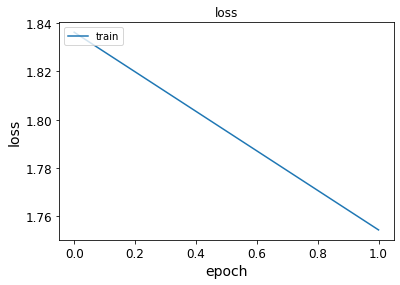

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Using the Model to Generate Text:

In [13]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

# Let's pass in 'How are yo' and see what it predicts the next letter should be:
X_new = preprocess(["How are yo"])

#this line takes a look at the softmax output and returns the max
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [14]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [15]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [16]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

**Temperature** controls the randomness of the outputs, a larger temperature means a less confident, but more random output (more errors, less logic), while a lower temperature is a more confident but less random output. Take a look below to see how temperature influences the predictions. 

In [17]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.3))

the state and though a strange and belly her to the


In [18]:
print(complete_text("t", temperature=1))

to compa
do you delpoble construct your hondures.
y


In [19]:
print(complete_text("t", temperature=2))


tpeniome
that? it?

jude:
lebevil! deniburs:
-y! er


# In Class Exercise: 

With your group, answer the following:
- Play around with the `complete_text` function, try different character lengths. What is the best output you got? 

- Do you think we trained the model long enough? Do you expect the predictions to be better if we made the model larger or trained the model longer? Why or why not?
  - i do think the model would be better if it was trained for longer, we only did 2 epochs, so we could get better results with more epochs

- Does anything surprise you about the predictions? Why or why not?
  - alot of the words are almost english, instead of real words

- How would you go about improving the model? What hyperparameters would you consider changing?
  - temperature



In [21]:
print(complete_text("the", temperature=0.5, n_chars=1000))

the love to the roys!
what shall not feals in the tine to their farst and patter with leave to come
the worse to the country as men see the rish.

first citizen:
where make you wood what in love.

first citizen:
gentleman we live do you say you than accors and lentle of the belly worst be belly with your elee.

menenius:
sir, i will make me, tranio,
the string on their trumio, i say he please the sack me with these are to they sholl the receive
in purpering be free the fit a good worth to head to my time to the cortune.

first citizen:
the tore my father that as the begs this charce
and i must in her and since be the sins to the condress to
patition and strong the their was make not be are and the nortens of the country
that me to the begs to the rome and me to fare his trucks
what all the rate make so who enders who have the groan on all comes
the change you have heart word,
that i know you may not though me for the words, the all instruction your lives
to the device to the dear and w